In [1]:
cd ..

/home/janek/reasonable-embeddings


In [12]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *

In [20]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [21]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [23]:
len(data_tr[2])

54490

In [26]:
len(data_tr[2])*(np.mean(data_tr[2]) - np.mean(data_te_vl[2])) 

589.7152194211008

In [28]:
len(data_te_tr[2])

27136

In [29]:
len(data_te_vl[2])

6426

In [22]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.7203 | val loss 0.7206 | acc 0.2125 | f1 0.3505 | prec 0.2125 | recall 0.9994 | roc auc 0.5276 | pr auc 0.2303 | elapsed 18.49s
train epoch 01/10 | batch 1704/1703 | loss 0.5887 | val loss 0.5075 | acc 0.7977 | f1 0.1010 | prec 0.9119 | recall 0.0535 | roc auc 0.5887 | pr auc 0.3263 | elapsed 32.56s
train epoch 02/10 | batch 1704/1703 | loss 0.4513 | val loss 0.4798 | acc 0.8014 | f1 0.2443 | prec 0.6388 | recall 0.1510 | roc auc 0.7002 | pr auc 0.4375 | elapsed 35.94s
train epoch 03/10 | batch 1704/1703 | loss 0.3392 | val loss 0.4876 | acc 0.8107 | f1 0.3945 | prec 0.6164 | recall 0.2901 | roc auc 0.7380 | pr auc 0.5131 | elapsed 32.27s
train epoch 04/10 | batch 1704/1703 | loss 0.2571 | val loss 0.5076 | acc 0.8187 | f1 0.4688 | prec 0.6218 | recall 0.3762 | roc auc 0.7498 | pr auc 0.5529 | elapsed 31.43s
train epoch 05/10 | batch 1704/1703 | loss 0.2085 |

In [16]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 1.0074 | val loss 1.0325 | acc 0.6659 | f1 0.3578 | prec 0.2978 | recall 0.4479 | roc auc 0.6225 | pr auc 0.3759 | elapsed 7.98s
train epoch 01/10 | batch 849/848 | loss 0.8721 | val loss 0.9117 | acc 0.6948 | f1 0.3697 | prec 0.3238 | recall 0.4307 | roc auc 0.6480 | pr auc 0.4016 | elapsed 14.00s
train epoch 02/10 | batch 849/848 | loss 0.6212 | val loss 0.8245 | acc 0.7247 | f1 0.3919 | prec 0.3621 | recall 0.4270 | roc auc 0.6716 | pr auc 0.4279 | elapsed 13.88s
train epoch 03/10 | batch 849/848 | loss 0.4466 | val loss 0.7665 | acc 0.7456 | f1 0.4112 | prec 0.3960 | recall 0.4277 | roc auc 0.6917 | pr auc 0.4525 | elapsed 14.70s
train epoch 04/10 | batch 849/848 | loss 0.3337 | val loss 0.7292 | acc 0.7631 | f1 0.4359 | prec 0.4314 | recall 0.4404 | roc auc 0.7073 | pr auc 0.4744 | elapsed 13.36s
train epoch 05/10 | batch 849/848 | loss 0.2632 | val loss 0.7051 | acc 0.7747 | f1 0.4511 | prec 0.4566 | recall 0.4457 | roc au

In [17]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240713T172026


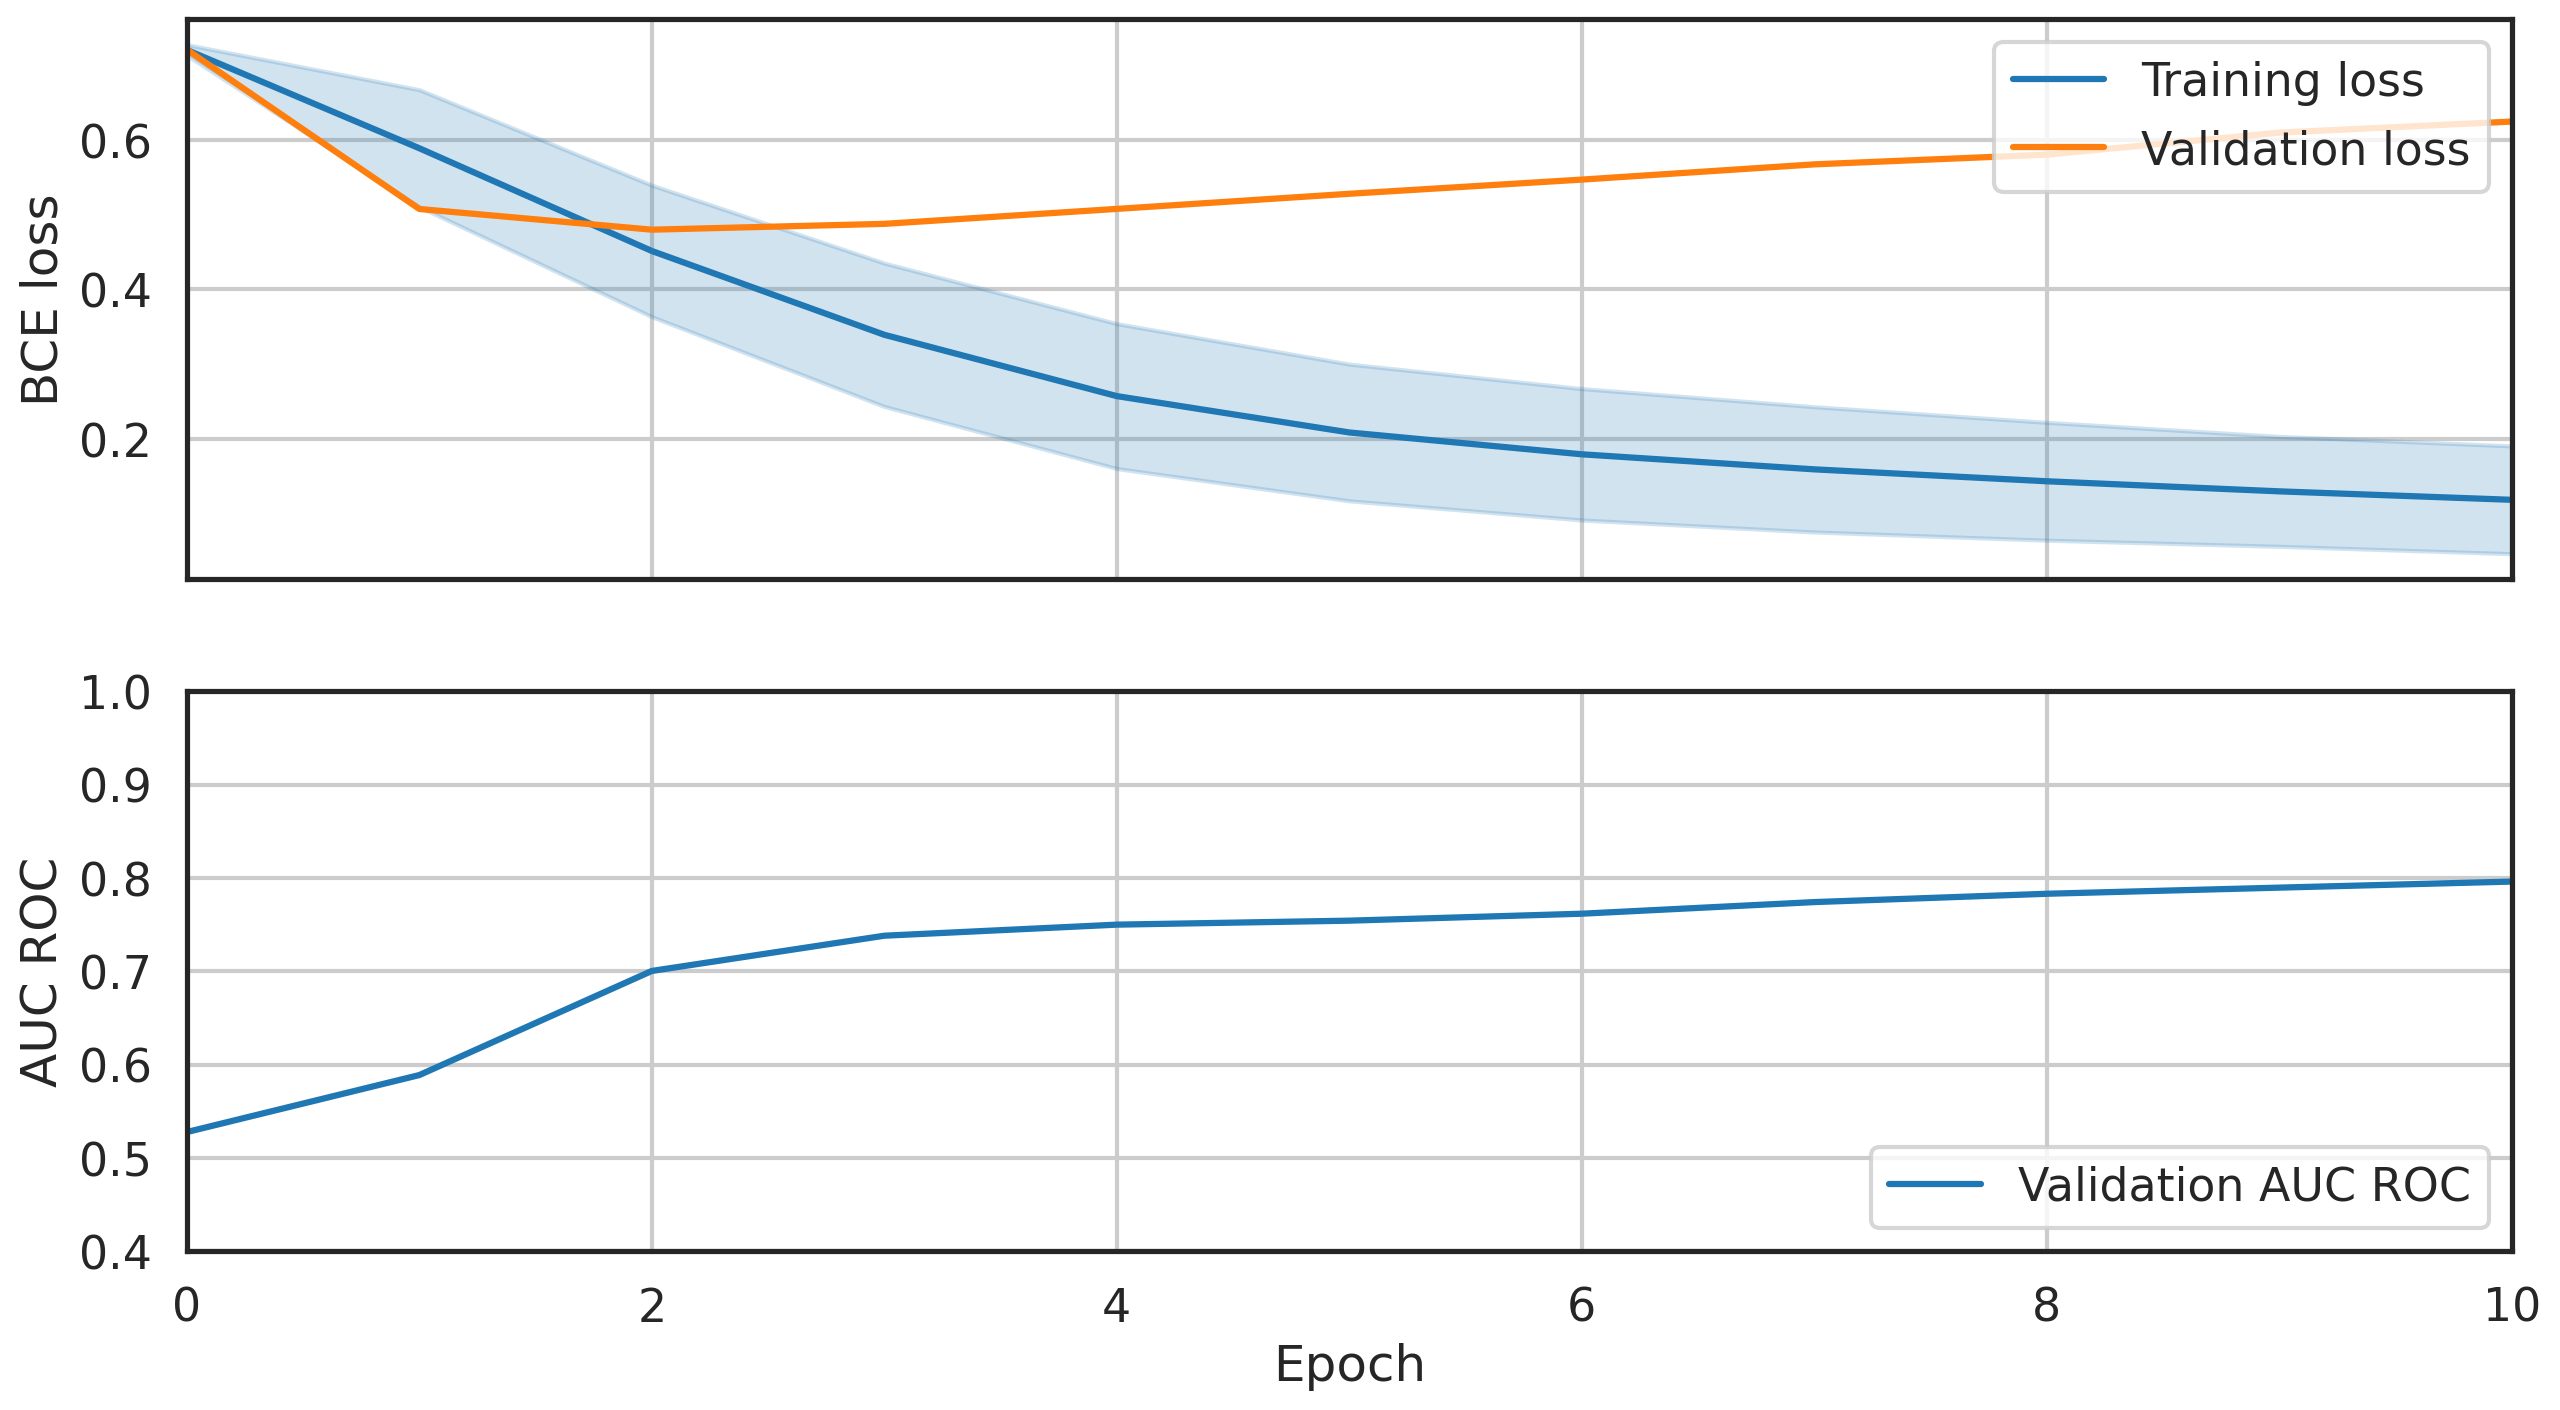

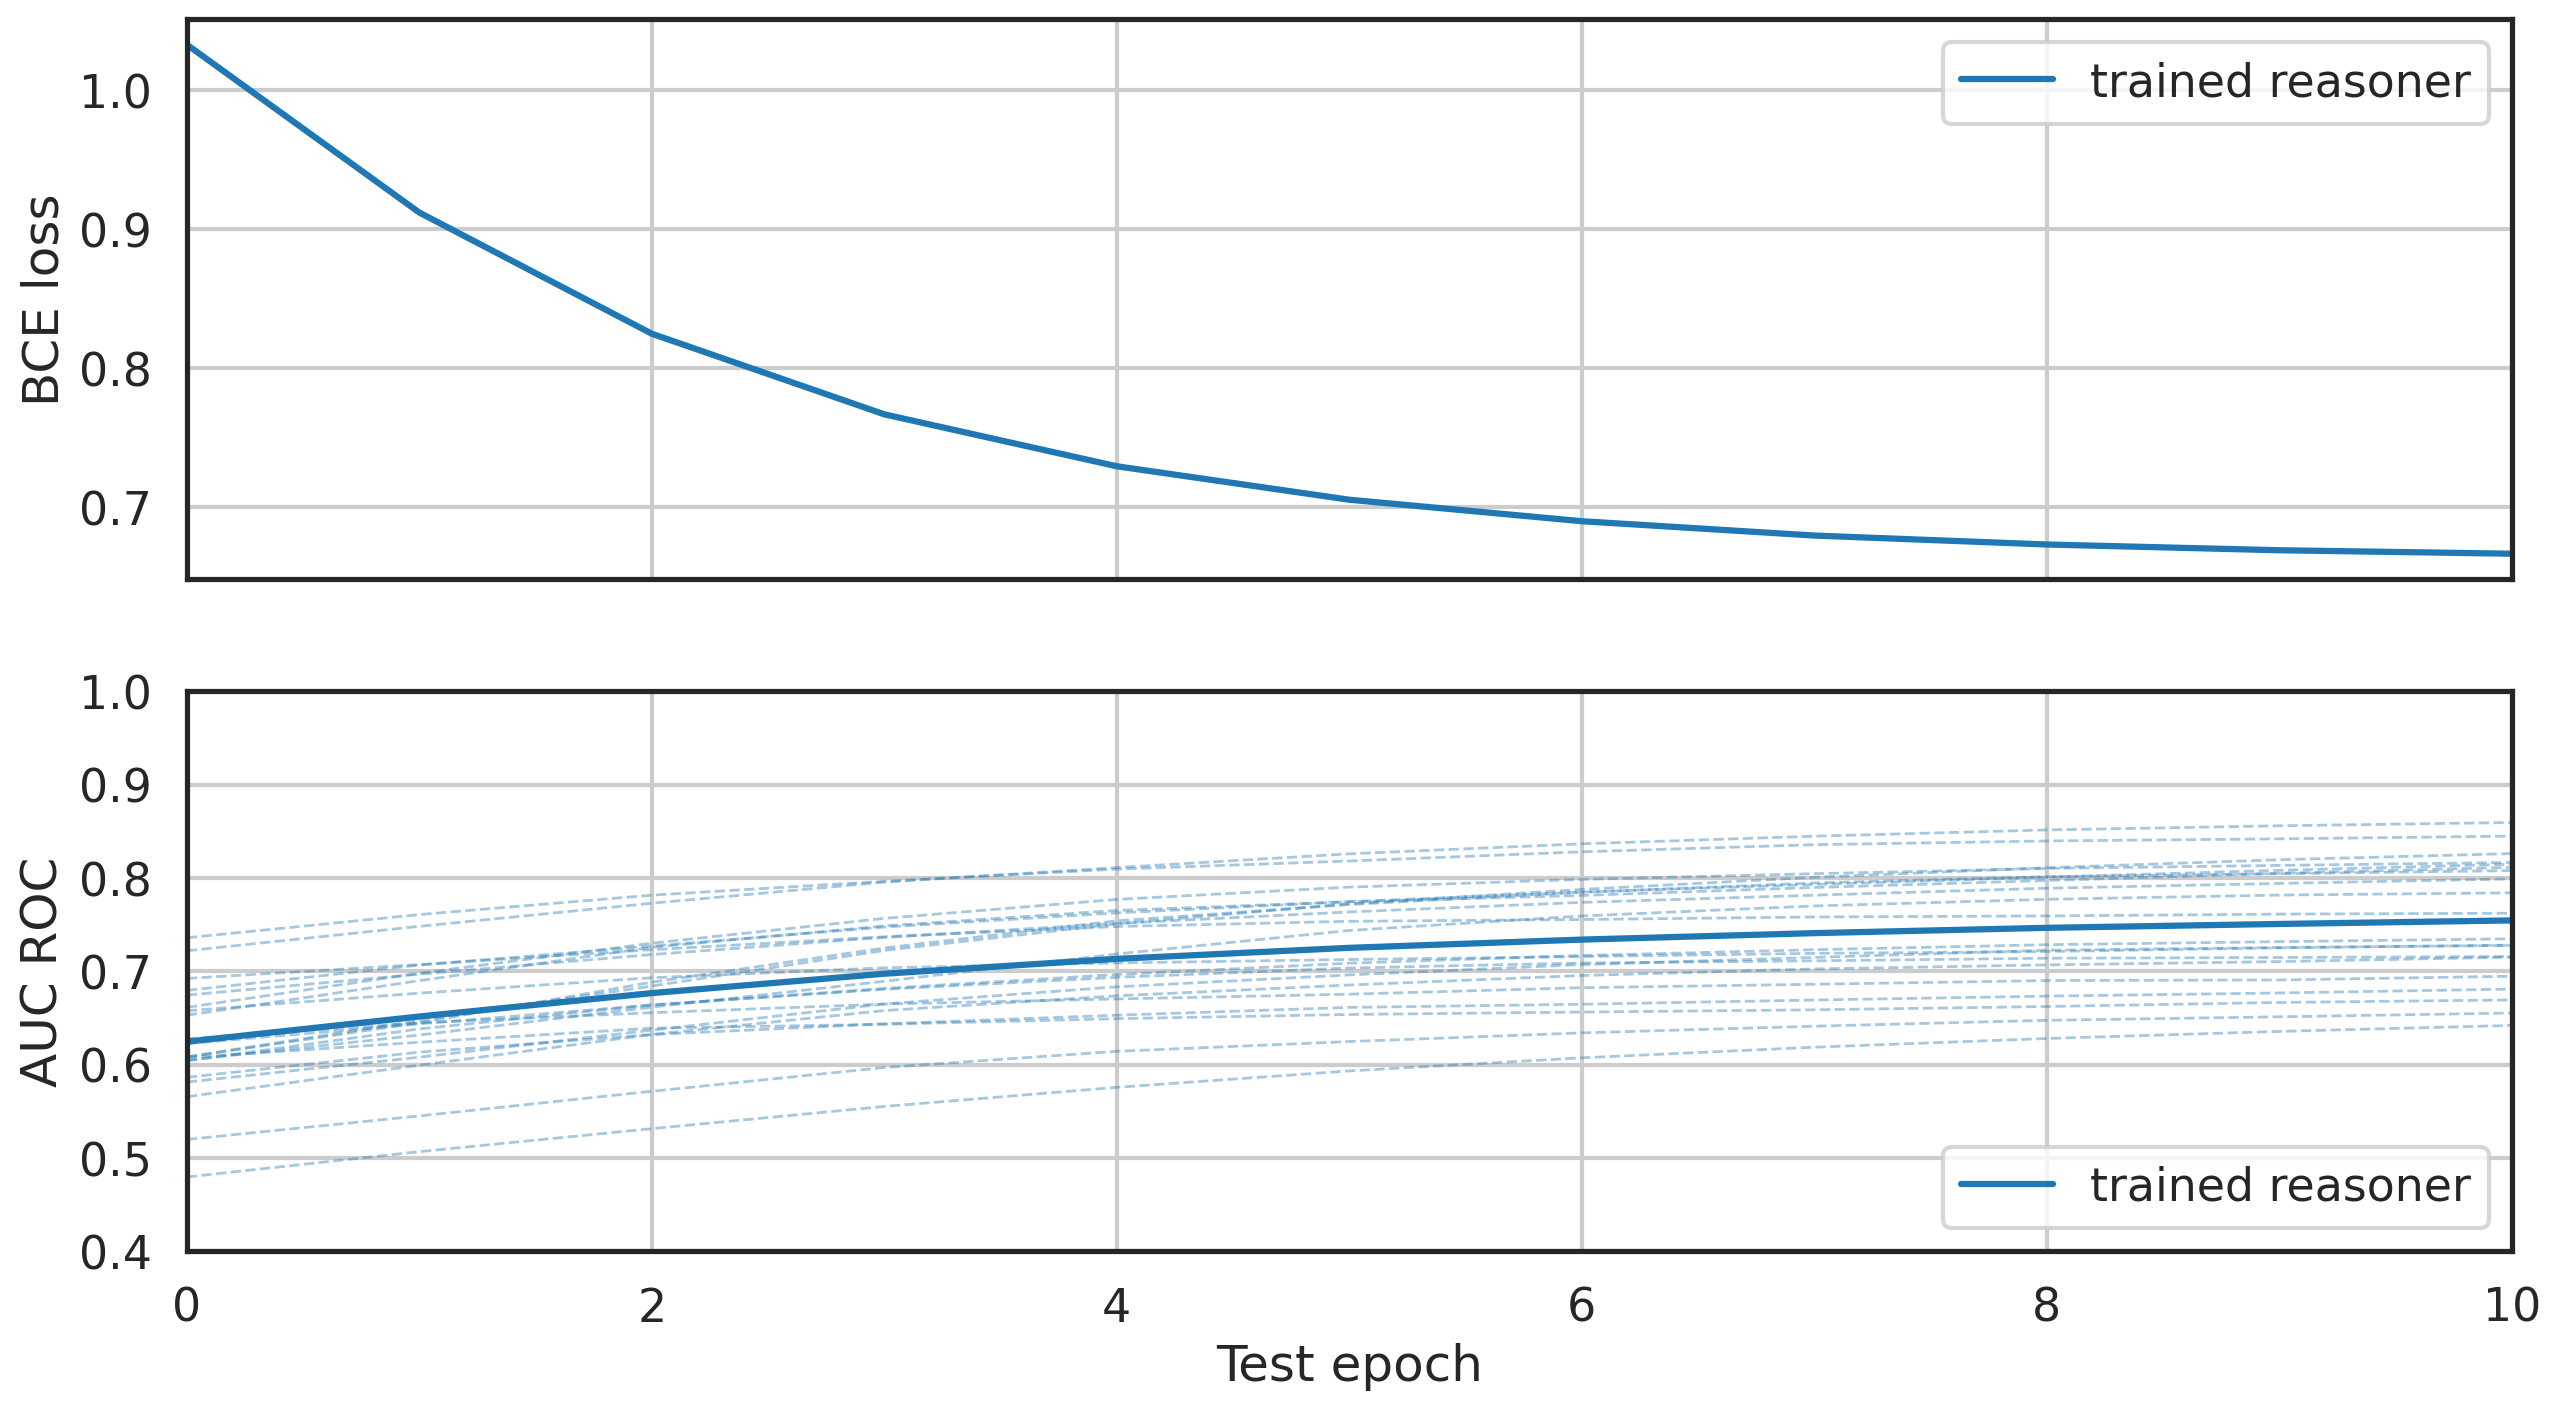

             mean       std     micro
acc      0.813915  0.051096  0.813451
prec     0.591420  0.149075  0.557403
recall   0.527353  0.101861  0.523031
f1       0.539918  0.066820  0.539670
auc_roc  0.783943  0.056686  0.775873
auc_pr   0.616911  0.085483  0.592375


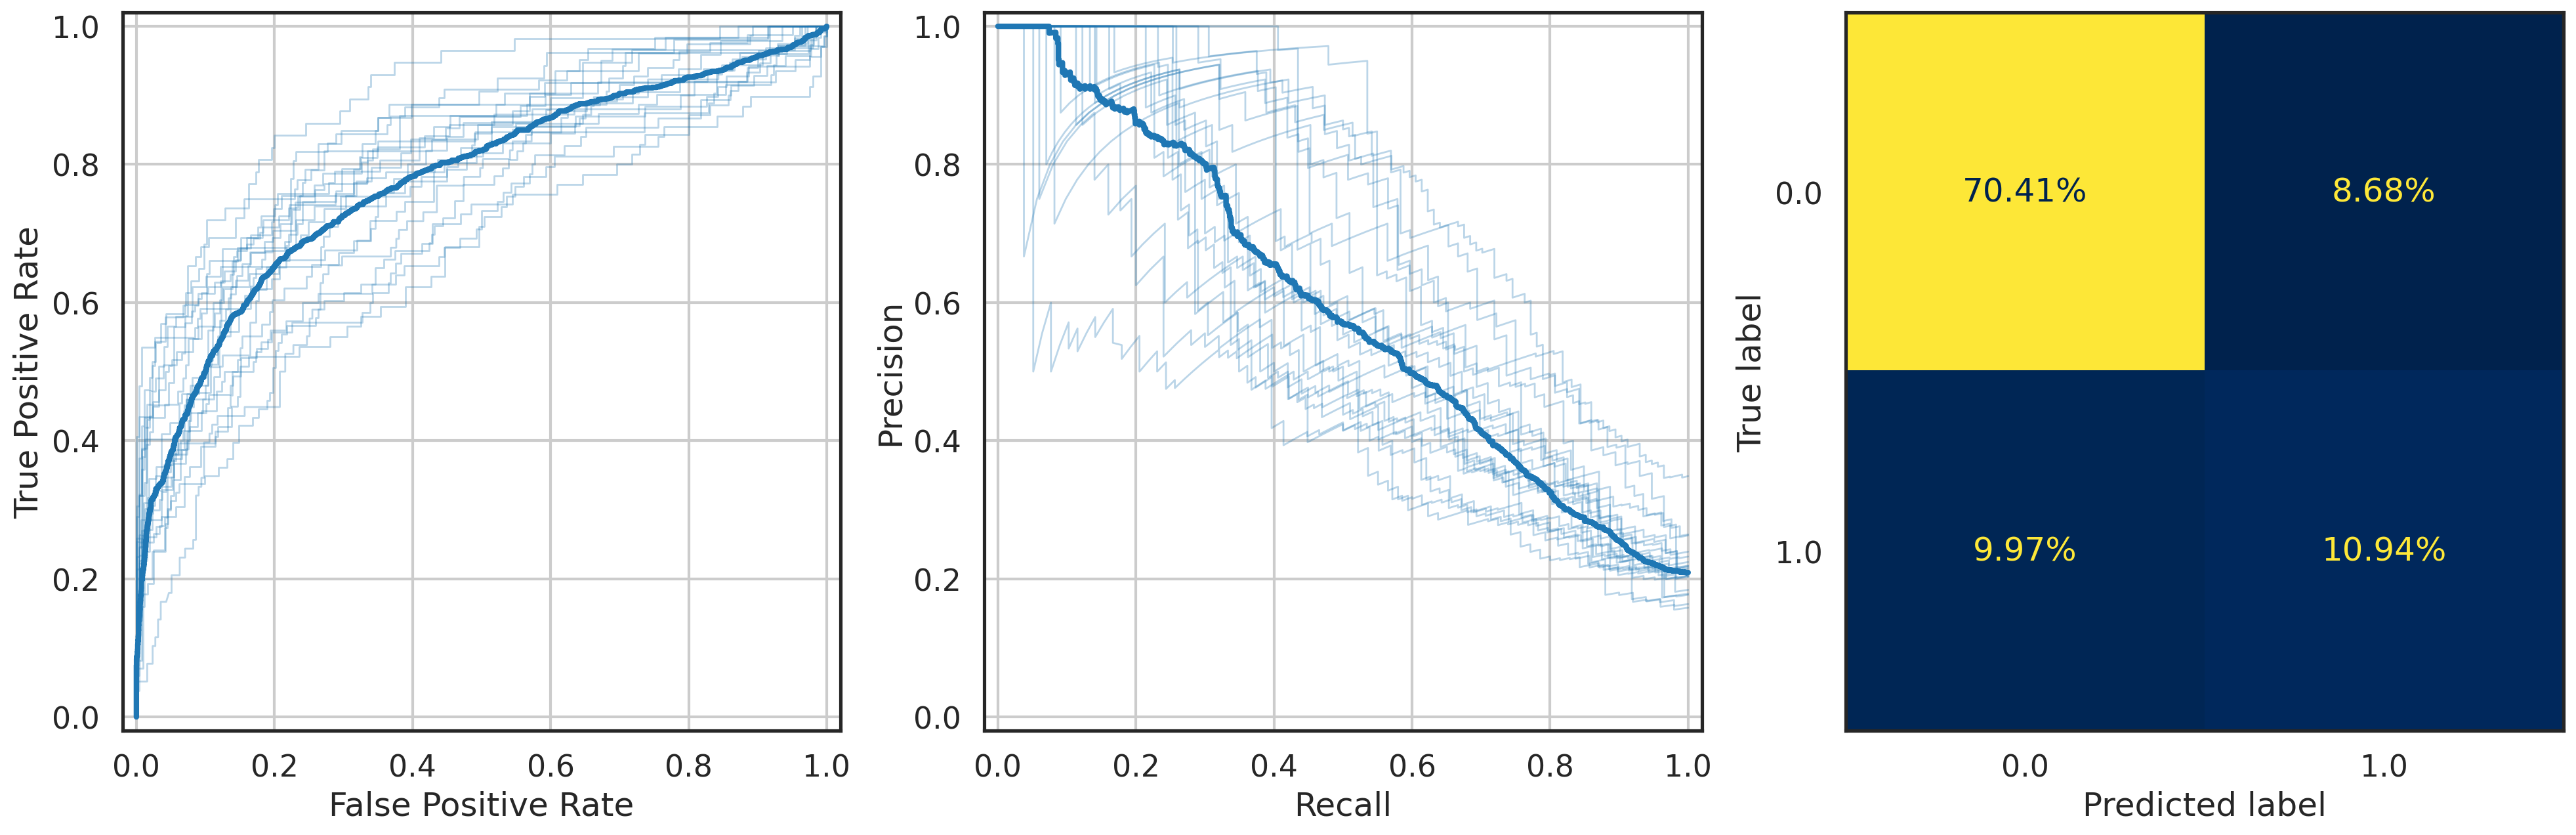

In [18]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [ ]:
import random

In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.0083, -0.0069,  0.1227, -0.2118,  0.2866,  0.0766,  0.1955, -0.0810,
        -0.1399, -0.0305], grad_fn=<SelectBackward0>)
tensor([ 0.0276,  0.0866, -0.1841,  0.1309, -0.0514,  0.0938, -0.0338,  0.0949,
        -0.1288, -0.0898], grad_fn=<AddBackward0>)
0.12055177204310893


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([-0.1661, -0.4832,  0.6680,  0.6558, -0.7554,  0.6556, -0.4838,  0.1988,
        -0.2138, -0.0831], grad_fn=<SelectBackward0>)
tensor([-0.4656, -0.3806,  0.4177, -0.0398,  0.6143, -0.5971,  0.3850, -0.3747,
         0.6262,  0.2059], grad_fn=<AddBackward0>)
0.6784895628690719


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.0206,  0.1015,  0.0297,  0.0421, -0.1607, -0.1550, -0.0425,  0.0842,
         0.0867, -0.0342], grad_fn=<SelectBackward0>)
tensor([ 0.0312,  0.1219, -0.0949,  0.1660,  0.1256,  0.0783, -0.0802, -0.0444,
        -0.0564, -0.0864], grad_fn=<AddBackward0>)
0.15921794511377813


In [ ]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([-0.1661, -0.4832,  0.6680,  0.6558, -0.7554,  0.6556, -0.4838,  0.1988,
        -0.2138, -0.0831], grad_fn=<SelectBackward0>)
tensor([-0.0501, -0.1106,  0.0332,  0.1005,  0.1968, -0.1144,  0.2349, -0.0978,
         0.0924,  0.0295], grad_fn=<AddBackward0>)
0.4553703084588051


In [ ]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([-0.1661, -0.4832,  0.6680,  0.6558, -0.7554,  0.6556, -0.4838,  0.1988,
        -0.2138, -0.0831], grad_fn=<SelectBackward0>)
tensor([ 0.2197,  0.4595,  0.6934,  0.4535,  0.0982, -0.2033, -0.2261,  0.4857,
         0.4535, -0.5037], grad_fn=<AddBackward0>)
tensor(0.4901, grad_fn=<L1LossBackward0>)


In [ ]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.4139,  0.0910,  0.3017, -0.0484,  0.3234, -0.8735, -0.8754,  0.8373,
        -0.0993, -0.0815], grad_fn=<SelectBackward0>)
tensor([ 0.2606,  0.4416,  0.1712,  0.1669, -0.1973, -0.0202, -0.1408,  0.2297,
        -0.3224, -0.4886], grad_fn=<AddBackward0>)
tensor(0.4196, grad_fn=<L1LossBackward0>)


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.0329,  0.0612, -0.1089,  0.2075,  0.0378,  0.0712, -0.0072,  0.0082,
        -0.0266, -0.0501], grad_fn=<AddBackward0>)
tensor([-0.0258,  0.0005, -0.0377,  0.1007,  0.1105, -0.0333,  0.1231, -0.0126,
         0.0415, -0.0105], grad_fn=<AddBackward0>)
0.06766295693814754


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([-0.0485, -0.0007, -0.0696,  0.1169,  0.0855, -0.0264,  0.0217, -0.0069,
         0.0352, -0.0390], grad_fn=<AddBackward0>)
tensor([-0.0067, -0.0241, -0.0432,  0.1034,  0.1180, -0.0103,  0.1035, -0.0353,
         0.0160, -0.0442], grad_fn=<AddBackward0>)
0.037960254680365325


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.3296,  0.0449, -0.2215,  0.2564, -0.1920,  0.2758, -0.0233, -0.0008,
        -0.0226,  0.4297], grad_fn=<SelectBackward0>)
tensor([-0.1464, -0.0456,  0.1830,  0.3241,  0.2187, -0.2739,  0.1247, -0.0701,
         0.1431,  0.0852], grad_fn=<AddBackward0>)
0.18198574110865592


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9906126171350479


In [ ]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9960722923278809
